<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/SolarData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Solar Data

In this section, we will load the solar data into Colab and put it into two arrays - one, named X, will contain all of the known data with 10 features, and the other, y, will contain the class numbers for each datapoint in X

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()  #Upload asu_solar_dataset.csv here

Saving asu_solar_dataset.csv to asu_solar_dataset.csv


In [3]:
data_path = '/content/asu_solar_dataset.csv'
df = pd.read_csv(data_path, delimiter=',')  #here we're reading our csv file into a Pandas DataFrame

In [4]:
# This is what our dataframe looks like to begin with
df.loc[0:2, :]  # We're only looking at the first three rows

,DCArrayOutput_W_,Vmp,Imp,CellTemperature_C_,PlaneOfArrayIrradiance_W_m_2_,Fill Factor,Gamma,Pmp,Voc,Isc,Degraded,Shaded,Soiled,SC,STC
0,4715.409,36.331723,1.369981,16.107,281.111,4.669695,0.177061,49.773762,44.338856,5.242090,0,0,0,0,1
1,9076.926,37.436438,2.559325,26.713,527.216,2.391698,0.181732,95.811997,44.023777,5.205219,0,0,0,0,1
2,11978.364,35.924148,3.519590,36.542,712.905,1.913899,0.177356,126.438287,45.239121,5.349134,0,0,0,0,1


In [5]:
# We're going to start by separating the data from the labels.  Here, 
# we delete the labels to isolate the data into a new dataframe

df_X = df.drop(columns=['Degraded', 'Shaded', 'Soiled', 'SC', 'STC'])
df_X #.loc[0:2,:] #Look at the dataframe to verify the 

,DCArrayOutput_W_,Vmp,Imp,CellTemperature_C_,PlaneOfArrayIrradiance_W_m_2_,Fill Factor,Gamma,Pmp,Voc,Isc
0,4715.409,36.331723,1.369981,16.107,281.11100,4.669695,0.177061,49.773762,44.338856,5.242090
1,9076.926,37.436438,2.559325,26.713,527.21600,2.391698,0.181732,95.811997,44.023777,5.205219
2,11978.364,35.924148,3.519590,36.542,712.90500,1.913899,0.177356,126.438287,45.239121,5.349134
3,13606.691,35.296861,4.069092,40.619,820.48600,1.637532,0.175050,143.626183,44.804407,5.249316
4,13953.936,34.555717,4.262436,45.436,861.07700,1.629109,0.171055,147.291547,44.492927,5.393082
...,...,...,...,...,...,...,...,...,...,...
21480,9918.107,32.878335,3.184198,56.338,648.85575,2.231807,0.161347,104.691129,44.903990,5.203332
21481,9498.023,32.857103,3.051301,56.476,622.77825,2.355273,0.160983,100.256909,44.016109,5.364680
21482,8470.261,34.315388,2.605487,46.998,531.26175,2.607679,0.168294,89.408311,44.419803,5.248744
21483,6168.314,34.718963,1.875344,44.375,389.89800,3.547519,0.166992,65.109981,44.582852,5.180891


In [6]:
# Here, we drop the data to obtain the labels.  We put them in their own dataframe.

df_y = df.drop(columns=['DCArrayOutput_W_', 'Vmp', 'Imp', 'CellTemperature_C_', 
                        'PlaneOfArrayIrradiance_W_m_2_', 'Fill Factor', 'Gamma',
                        'Pmp', 'Voc', 'Isc'])
df_y #.loc[:3,:] #Labels in a one-hot encoding

,Degraded,Shaded,Soiled,SC,STC
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
21480,0,1,0,0,0
21481,0,1,0,0,0
21482,0,1,0,0,0
21483,0,1,0,0,0


In [7]:
#Now we convert the data into a numpy array - many of the algorithms we're 
#interested in will only take numpy arrays, not dataframes
X = df_X.to_numpy()
X[:3,:] #check to make sure it converted it properly

array([[4.71540900e+03, 3.63317230e+01, 1.36998076e+00, 1.61070000e+01,
        2.81111000e+02, 4.66969485e+00, 1.77060882e-01, 4.97737617e+01,
        4.43388563e+01, 5.24209008e+00],
       [9.07692600e+03, 3.74364378e+01, 2.55932461e+00, 2.67130000e+01,
        5.27216000e+02, 2.39169826e+00, 1.81731959e-01, 9.58119967e+01,
        4.40237770e+01, 5.20521867e+00],
       [1.19783640e+04, 3.59241479e+01, 3.51959042e+00, 3.65420000e+01,
        7.12905000e+02, 1.91389893e+00, 1.77356431e-01, 1.26438287e+02,
        4.52391213e+01, 5.34913355e+00]])

In [8]:
# Data labels are originally stored in a one-hot encoding, meaning that each 
# column represents a fault type and contains either a zero or a 1
y_onehot = df_y.to_numpy()
y_onehot[:3,:]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [9]:
# We will covert the one-hot encoding into integer class numbers.
y = np.argmax(y_onehot, axis=1)

# Here, 0 = degraded
#       1 = shaded
#       2 = soiled
#       3 = short circuit
#       4 = standard test conditions (no faults)

print(y)
print(y.shape)

[4 4 4 ... 1 1 1]
(21485,)


# Visualize the Data (Using Dimensionality Reduction)

In order to visualize the 10 dimensional data effectively, we're going to perform a dimensionality reduction algorithm called PCA (Principal Component Analysis).  This uses Singular Value Decomposition to identify the eigenvectors in the data, and removes all but the most important.

In [10]:
from sklearn.decomposition import PCA

# Transform the data into a dimensionality reduced dataset in 3 dimensions
pca_model3 = PCA(n_components=3)
X_red3 = pca_model3.fit_transform(X)  #X_red is short for X_reduced3

In [11]:
X_red3[1:3,:]

array([[ 1.80730409e+03, -1.28337250e+02, -5.74421433e+00],
       [ 4.71475626e+03, -1.50077960e+02,  4.17291284e+00]])

In [12]:
# Here, we can plot the reduced data in three dimensions

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=X_red3[:,0], y=X_red3[:,1], z=X_red3[:,2], 
                                   mode='markers', 
                                   marker=dict(
                                       size=5,
                                       color=y,                
                                       opacity=0.8))])

fig.show()


Hmmm.... It looks like the third dimension doesn't really add that much.  Let's see what happens if we plot it in only two dimensions

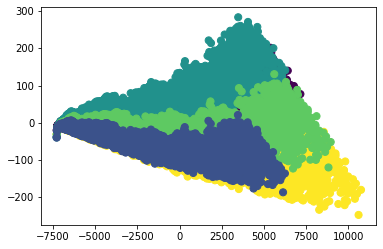

In [13]:
# Transform the data into a dimensionality reduced dataset in 2 dimensions
pca_model2 = PCA(n_components=2)
X_red2 = pca_model2.fit_transform(X)  #X_red2 is short for X_reduced2

plt.scatter(X_red2[:, 0], X_red2[:, 1], s=50, c=y)


#Legend:
#   purple = degraded
#   blue = shaded
#   cyan = soiled
#   green = short circuit
#   yellow = STC (no faults or problems)

#Binary Classification

First, let's identify which classes we will be comparing.

Let's start with classifying soiled vs STC (no problem data)

In [15]:
X_soiled = X[y == 2]
X_STC = X[y == 4]

y_soiled = np.ones((X_soiled.shape[0], ))
y_STC = np.zeros((X_STC.shape[0], ))

print('X_soiled.shape: ', X_soiled.shape)
print('X_STC.shape: ', X_STC.shape)

X_bin = np.concatenate((X_soiled, X_STC), axis=0)
y_bin = np.concatenate((y_soiled, y_STC), axis=0)

print("\nX_bin.shape: ", X_bin.shape)
print("y_bin.shape: ", y_bin.shape)

X_soiled.shape:  (4297, 10)
X_STC.shape:  (4297, 10)

X_bin.shape:  (8594, 10)
y_bin.shape:  (8594,)


Break the data into training, validation, and test sets

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test_and_val, y_train, y_test_and_val = train_test_split(X_bin, y_bin, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test_and_val, y_test_and_val, test_size=0.5)

print("train_size = ", x_train.shape[0])
print("val_size = ", x_val.shape[0])
print("test_size = ",  x_test.shape[0])

train_size =  6015
val_size =  1290
test_size =  1289


Train and test on the validation set while we try out different hyperparameter combination.  Hyperparameters in this example are the solver and the number of itterations.

In [17]:
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.metrics import accuracy_score

#Train and test on validation set
LR_model = LogisticRegression(random_state=0, solver='liblinear', max_iter=1000)

sim_model = LR_model.fit(x_train, y_train)
y_hat = sim_model.predict(x_val)

accuracy = accuracy_score(y_val, y_hat)
print('Validation accuracy = ', accuracy)

Validation accuracy =  0.9782945736434109


Once we have identified the ideal combination of hyperparameters, we want to retrain the data on the original training and validation data, so we can do a final test on the reserved test data.

In [18]:
x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
sim_model_val = LR_model.fit(x_train_val, y_train_val)

y_hat_test = sim_model_val.predict(x_test)

We can plot the confusion matrix and summary statistics.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



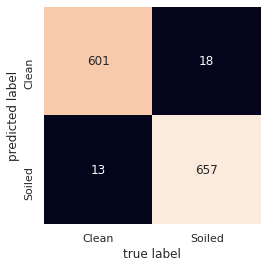

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

CM = confusion_matrix(y_test, y_hat_test)
ax = sns.heatmap(CM.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Clean','Soiled'],
            yticklabels=['Clean','Soiled'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

Next, let's print out some summary statistics.  

Recall that we called clean (STC) negative and soiled is positive.

  * $TN$ = true negatives (clean panels that were correctly classified as clean)
  * $FP$ = false positives (clean panels that were incorrectly classified as dirty)
  * $FN$ = false negatives (dirty panels that were incorrectly classified as clean)
  * $TP$ = true positives (dirty panels that were correctly classified as dirty)

Some common summary statistics are:

* Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$ 


When the class sizes are imballanced, the F-score (or F1-score) is a better metric than accuracy.  It is equal to the harmonic mean between precision and recall.  Like accuracy, it ranges between 0 and 1.


* Precision = $\frac{TP}{TP + FP}$


* Recall = $\frac{TP}{TP + FP}$


* F-Score = $2*\frac{Precision \times Recall}{Precision + Recall}$




In [20]:
from sklearn.metrics import f1_score

TN, FP, FN, TP = CM.ravel()

precision = TP/(TP+FP)  #sklearn also has functions to calculate these
recall = TP/(TP+FN)     #or you can calculate them manually
accuracy = accuracy_score(y_test, y_hat_test) #these are calculated automatically
f1_score = f1_score(y_test, y_hat_test)       #using sklearn.

print('Test accuracy = ', accuracy)
print('F-score = ', f1_score)
print('Precision = ', precision)
print('Recall = ', recall)

Test accuracy =  0.9759503491078355
F-score =  0.9769516728624535
Precision =  0.9805970149253731
Recall =  0.9733333333333334


#Multi-class classification

In [21]:
x_train_mc, x_test_and_val_mc, y_train_mc, y_test_and_val_mc = train_test_split(X, y, test_size=0.3)
x_test_mc, x_val_mc, y_test_mc, y_val_mc = train_test_split(x_test_and_val_mc, y_test_and_val_mc, test_size=0.5)

print("train_size = ", x_train.shape[0])
print("val_size = ", x_val.shape[0])
print("test_size = ",  x_test.shape[0])

train_size =  6015
val_size =  1290
test_size =  1289


In [47]:
#Train and test on validation set
LR_model_mc = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)

sim_model_mc = LR_model.fit(x_train_mc, y_train_mc)
y_hat_mc = sim_model.predict(x_val_mc)

accuracy_mc = accuracy_score(y_val_mc, y_hat_mc)
print('Validation accuracy = ', accuracy_mc)

Validation accuracy =  0.7731926776295377


In [48]:
# Now that we've used the validation set to identify the best solver and number 
# of itterations, we want to recombine our data so we can train our network on
# as much data as possible so we can use the test set for final testing.
x_train_val_mc = np.concatenate((x_train_mc, x_val_mc), axis=0)
y_train_val_mc = np.concatenate((y_train_mc, y_val_mc), axis=0)
sim_model_val_mc = LR_model.fit(x_train_val_mc, y_train_val_mc)

y_hat_test_mc = sim_model_val.predict(x_test_mc)

final_accuracy_mc = accuracy_score(y_test_mc, y_hat_test_mc)
print('Test accuracy = ', accuracy_mc)

Test accuracy =  0.7731926776295377


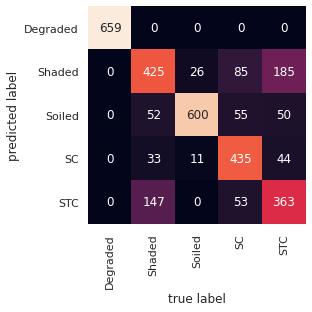

In [24]:
#   y=0: degraded
#   y=1: shaded
#   y=2: soiled
#   y=3: short circuit
#   y=4: STC

CM_mc = confusion_matrix(y_test_mc, y_hat_test_mc)
ax = sns.heatmap(CM_mc.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

#Unsupervised Clustering (K-Means)
How does unsupervised clustering compare with supervised classification?

We're going to start with our dimensionality reduced data so we can visualize the clusters.  Because some of the clusters overlap in our 3d data (as opposed to the original 10 dimensions), we do not expect this to be very effective.

In [42]:
from sklearn.cluster import k_means

# Recall that the dimensionality reduced data is called X_red3, and the labels are y
X_clustered_3d = X_red3
y_clustered_3d = y


# Also notice that we know there are 5 types of data, so we don't have to 
# try several different cluster nums to find the ideal number of clusters.

# Perform k-means clustering
centroids, y_clusters_3d_hat, cost = k_means(X_red3, n_clusters=5)


In [43]:
# Here, we can plot the reduced and clusterd data in three dimensions

fig = go.Figure(data=[go.Scatter3d(x=X_red3[:,0], y=X_red3[:,1], z=X_red3[:,2], 
                                   mode='markers', 
                                   marker=dict(
                                       size=5,
                                       color=y_clusters_3d_hat,                
                                       opacity=0.8))])

fig.show()

There are many possible clusterings that you'll see, but none of them do a great job.

We can evaluate our clustering as we know the true labels.

We were able to cluster digits with 26.37% accuracy.


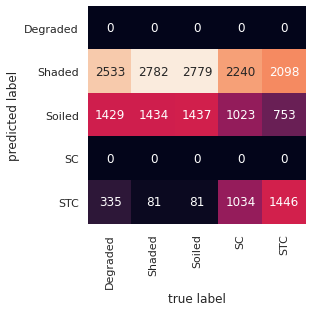

In [50]:
from scipy.stats import mode

# This will only work if the clusters overlap the actual classes to a reasonable 
# amount.  If they are way off, this will not be effective.
cluster_labels_3d = np.zeros_like(y_clusters_3d_hat)
for i in range(5):
    mask = (y_clusters_3d_hat == i)
    cluster_labels_3d[mask] = mode(y_clustered_3d[mask])[0]

# Determine the accuracy of our clustering
accuracy = accuracy_score(y_clustered_3d, cluster_labels_3d)
print("We were able to cluster digits with " + str(round(accuracy * 100, 2)) + "% accuracy.")

# Plot the confusion matrix
CM_clusters = confusion_matrix(y_clustered_3d, cluster_labels_3d)
ax = sns.heatmap(CM_clusters.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

If the above confusion matrix doesn't look right (one or more rows being all zeros), that's because the clustering is SO BAD that the technique we're doing to assign labels doesn't work.  In this case, the accuracy is more reliable than the confusion matrix.

Since that didn't work, let's see what happens if we cluster the data in the original 10 dimensions.  Notice that we can't visualize it in 10 dimensions, so we're stuck with the accuracy and confusion matrix to see how well the clustering works.

We were able to cluster digits with 26.36% accuracy.


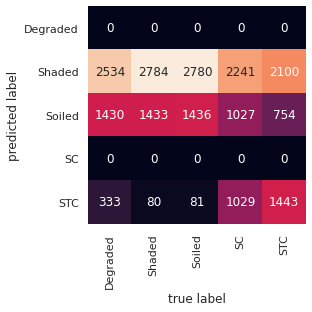

In [51]:
X_clustered_10d = X
y_clustered_10d = y

# Perform k-means clustering
centroids, y_clusters_10d_hat, cost = k_means(X_clustered_10d, n_clusters=5)

# This will only work if the clusters overlap the actual classes to a reasonable 
# amount.  If they are way off, this will not be effective.
cluster_labels_10d = np.zeros_like(y_clusters_10d_hat)
for i in range(5):
    mask = (y_clusters_10d_hat == i)
    cluster_labels_10d[mask] = mode(y_clustered_10d[mask])[0]

# Determine the accuracy of our clustering
accuracy = accuracy_score(y_clustered_10d, cluster_labels_10d)
print("We were able to cluster digits with " + str(round(accuracy * 100, 2)) + "% accuracy.")

# Plot the confusion matrix
CM_clusters = confusion_matrix(y_clustered_10d, cluster_labels_10d)
ax = sns.heatmap(CM_clusters.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

That didn't work at all!  It looks like clustering, even in 10 dimensions, is not an effective technique for this dataset.  In fact, it looks like we did slightly worse in 10 dimensions than we did in 3.  

So in this situation, supervised classification performs MUCH better than an unsupervised clustering.